# Policy & Value : A Love Story

In this notebook, we want to show how value and policy based models perform in two different settings :
- A Recommendation Setting with **Dense Reward** : We can think of a streaming plateform with rewards equal to the time spent on watching videos.
- A Recommendation Setting with **Sparse Reward** : We can think of a system serving Ads with the reward being the click on the Ad.

And how we can combine them in what is known in the litterature as **DRL** : Doubly Robust Learning to achieve better performances (or not) depending on the setting.

To make our comparison more complete, we are going to analyse theoretically DRL to shed light on the settings where it performs better than naive policy based learning.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from tqdm import tqdm

import seaborn as sns
sns.set()

import torch 
from torch import nn, optim

torch.manual_seed(0)
np.random.seed(0)

Before diving into the comparisons, we first need to build a simulator of the settings in which we want to compare our models.


In both settings :

- We denote by **d** the dimension of the **context** $x$ which are user features (interests, location, age etc). In our problem, $x \sim U([0,1])^d$.
- We denote by **K** the number of actions our system can perform (the number of movies it can recommend, the number of products we want to advertise etc)

Given a user context $x$, our system recommends the action $a$ and gets a reward $r(a,x)$ (its either dense $\in [0, 1]$ or binary $\in \{0, 1\}$ depending on the settings). It should be noted that in real world problems, the reward is a very complex function of both the contexts and actions, and we want to capture that with our simulator too.

To make the notebook as illustrative as possible, we take **d** = 10, and **K** = 5. Feel free to modify them to get a better intuition of the behavior of the different models in problems with bigger dimensions or larger action spaces.

In [2]:
d = 10
K = 5

The next code block defines how the reward is distributed given contexts and actions in both the binary (clicks) and dense (watchtimes) settings.

In [3]:
h = 2
eps = 0.1

theta_star_1 = np.random.randn(d, h)
theta_star_2 = np.random.rand(h, K)

def misspecification_transform(context):
    h1 = np.cos(context) + np.sin(context) - np.log(np.exp(context) + 1.) 
    h2 = h1@theta_star_1
    return h2

def true_mean_reward(context, action):
    h = misspecification_transform(context)
    return np.sin(h@theta_star_2[:,action]) + .8

def observed_reward(context, action, setting):
    
    if setting == 'dense': 
        return np.clip(true_mean_reward(context, action) + eps*np.random.randn() , 0., 2.)/2.
    
    return (1. + np.sign(-1.795 + true_mean_reward(context, action)))/2.
        

In our setting, we imagine that we don't have any information about the users that will interact with our system, and want to gather some data with which we're gonna build a good recommendation engine. To do so, we're gonna deploy a policy (system) that recommends products to users randomly. 

For any user context $x_i$, we show uniformly (with probability $p_i = \pi_0(a_i|x_i) = \frac{1}{K}$ a product $a_i$ from our catalog and get a feedback $r_i = r(x_i, a_i)$, we then log $D_i = (x_i, a_i, \pi_0(a_i|x_i), r_i)$

We denote by **N** the number of user contexts needed to build our first dataset $D = \{D_i\}_{\{1 \le i \le N\}}$.

In our example, **N = 5000** .

In [4]:
catalog = np.arange(K)
pi_0 = np.ones(K)/K

N = 5000

The next block defines the interaction routine of the online system with the users. (One routine to collect the data and one specialized in A/B Testing the models)

In [5]:
def online_system_simulator(current_system, size, setting = 'dense'):
    contexts, actions, propensities, rewards = [], [], [], []
    
    for _ in range(size):
        context = np.random.randn(d)
        action = np.random.choice(catalog, p = pi_0)
        propensity = current_system[action]
        reward = observed_reward(context, action, setting)

        contexts.append(context)
        actions.append(action)
        propensities.append(propensity)
        rewards.append(reward)
        
    return contexts, actions, propensities, rewards

def AB_test_greedy(models, size, setting = 'dense'):
    rewards = [[] for _ in range(len(models))]
    for _ in tqdm(range(size)):
        context = np.random.randn(d)
        torch_context = torch.Tensor(context)
        for i, model in enumerate(models):
            rewards_pred = model(torch_context).detach().numpy()
            action = np.argmax(rewards_pred)
            reward = observed_reward(context, action, setting)
            rewards[i].append(reward)
        
    return [np.mean(model_reward) for model_reward in rewards]

### Watch Time Setting : Dense Rewards 

We deploy our first system to collect/log a dataset from which we want to learn a good recommendation engine.

In [6]:
contexts, actions, propensities, rewards = online_system_simulator(current_system = pi_0, size = N)

Let's have a look at the distribution of the rewards gotten in this setting :

the average reward of the logging policy (Random) is 0.3250


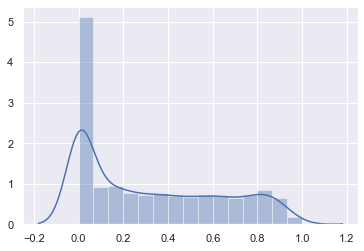

In [7]:
logging_results = np.mean(rewards)
print("the average reward of the logging policy (Random) is %.4f"%logging_results)
sns.distplot(rewards)
plt.show()

Let's compare how the different learning frameworks behave in this setting. We are going to use *simple linear functions* for both the reward model and the policy. In both cases, we are trying to learn a parameter $\theta$, which is a matrix of dimension **d x K**. 

All the models are implemented with Pytorch.

### Learning a Value model :

Our value model is a simple linear regression from the contexts to the reward vector for each action: $ \hat{r}_\theta(x,a) = \theta_a^Tx $ with $\theta_a$ being the ath column of our matrix.

For a single datapoint $D_i$, the loss function (the negative loglikelihood up to a constant) of our model is :

$$ LM(\hat{r}_\theta, D_i) = (\hat{r}_\theta(x_i, a_i) - r_i)^2 $$

We optimize the average loss over the whole datapoints to obtain the minimum $\hat{r}^*$.

In [8]:
class reward_model(torch.nn.Module):
    def __init__(self, d, K):
        super(reward_model, self).__init__()
        self.theta = torch.nn.Linear(d, K)

    def forward(self, x):
        return self.theta(x)

In [9]:
value_based_model = reward_model(d, K)

contexts_torch = torch.Tensor(contexts)
rewards_torch = torch.Tensor(rewards)
propensities_torch = torch.Tensor(propensities)

In [10]:
iterations = 50_000

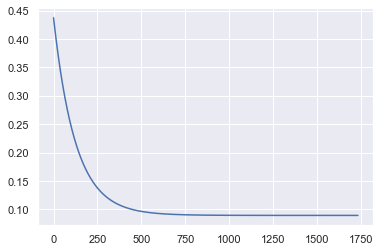

In [11]:
loss_function = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(value_based_model.parameters(), lr=1e-2, weight_decay=1/N)
losses = []

for it in range(iterations):
    full_rewards_pred = value_based_model(contexts_torch)
    action_rewards = full_rewards_pred[np.arange(N), actions]
    loss = loss_function(action_rewards, rewards_torch)
    losses.append(loss.item())
    if (it > 100) and np.isclose(losses[-1], losses[-2], atol=.0, rtol=1e-8) : break
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(np.arange(it + 1), losses)
plt.show()

### Learning a Policy with IPS :

Same for policy learning, we use a simple linear function transformed with a softmax to define probabilities for each context. 

$$ \pi_\theta(a|x) = \frac{\exp(\theta_a^Tx)}{\sum_a \exp(\theta_a^Tx)} $$ with $\theta_a$ being the ath column of our matrix.

For a single datapoint $D_i$, the loss function for policy learning is the IPS estimate:

$$ L_{IPS}(\pi_\theta, D_i) = -r_i\frac{\pi_\theta(a_i|x_i)}{\pi_0(a_i|x_i)} $$

We optimize the average loss over the whole datapoints to obtain a good policy $\pi^*$.

In [12]:
class policy_model(torch.nn.Module):
    def __init__(self, d, K):
        super(policy_model, self).__init__()
        self.theta = torch.nn.Linear(d, K)

    def forward(self, x):
        return nn.functional.softmax(self.theta(x), dim = -1)

In [13]:
policy_ips = policy_model(d, K)

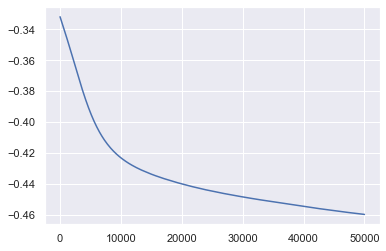

In [14]:
optimizer = torch.optim.SGD(policy_ips.parameters(), lr=1e-2, weight_decay=1/N)
losses = []

for it in range(iterations):
    policy_probs = policy_ips(contexts_torch)
    actions_probs = policy_probs[np.arange(N), actions]
    loss = - torch.mean((actions_probs * rewards_torch)/propensities_torch)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(np.arange(iterations), losses)
plt.show()

- You can observe that the loss of value learning converges directly to a minimum which is actually the global minimum as the loss (negative likelihood of a linear regression) is convex.
- For policy however, its loss is not convex and even after 50K Gradient Descent Iterations, the loss is still improving trying to saturate the learned policy.

### Testing the models online

The following block will launch an A/B test to test out both the models on a huge number of users to get a fair and noiseless comparison.

In [15]:
N_test = 100_000

In [16]:
models_to_test = [value_based_model, policy_ips]
value_result, policy_result = AB_test_greedy(models_to_test, N_test)

print('the reward for value based learning is %.4f'%value_result)
print('the reward for policy based learning - IPS is %.4f'%policy_result)

100%|██████████| 100000/100000 [00:23<00:00, 4312.53it/s]

the reward for value based learning is 0.3997
the reward for policy based learning - IPS is 0.4104


One can see that policy based learning gets the upper hand slightly because of different factors:

- The reward model is clearly miss-specified.
- We have a small action space/enough datapoints.
- A random logging policy.

To get a grasp of the theory discussed in the slides and get different behaviors of the learning methods, we highly encourage you to try to :

- Increase the number of actions. (Change K)
- Modify the number of points we collect. (Change N)
- Increase the complexity of the reward model. (Use a Deep neural network instead of a linear function)
- Change the logging policy. (It is random in this example)


In this notebook, our focus is to present one of the classic methods of combining the reward model with policy learning, and be able to distinguish the cases where it can do wonders and others where it can only do harm.

### Doubly Robust Learning : A way to reduce variance of the IPS Estimator

Having learned a good reward model $\hat{r}^*$, one defines the doubly robust objective (which is unbiased) as follows :

$$ L_{DR}(\pi_\theta, D_i) := - [r_i - \hat{r}^*(a_i, x_i)]\frac{\pi_\theta(a_i|x_i)}{\pi_0(a_i|x_i)} - \sum_a \pi_\theta(a|x_i)\hat{r}^*(a, x_i) $$

One can see that this loss function has an increased computational cost as it involves a sum over all possible actions + a computation of the estimated reward. (very costly if the action space is large or the reward model is very costly to compute), so what does it bring to the table? Let's analyse the variance of this estimator! 

We have :

$$ Var(L_{DR}(\pi_\theta, D_i)) = Var(L_{IPS}(\pi_\theta, D_i)) + Var[\hat{r}^*(a_i, x_i)\frac{\pi_\theta(a_i|x_i)}{\pi_0(a_i|x_i)}] - 2Cov(r_i\frac{\pi_\theta(a_i|x_i)}{\pi_0(a_i|x_i)}, \hat{r}^*(a_i, x_i)\frac{\pi_\theta(a_i|x_i)}{\pi_0(a_i|x_i)}) $$

We obtain a variance reduction from the simple IPS objective when $Var(L_{DR}) \le Var(L_{IPS})$, which is actually when :

\begin{align} 
Var[\hat{r}^*(a_i, x_i)\frac{\pi_\theta(a_i|x_i)}{\pi_0(a_i|x_i)}] \le 2Cov(r_i\frac{\pi_\theta(a_i|x_i)}{\pi_0(a_i|x_i)}, \hat{r}^*(a_i, x_i)\frac{\pi_\theta(a_i|x_i)}{\pi_0(a_i|x_i)})
\end{align}

which means that we need a significant covariance between $r_i\frac{\pi_\theta(a_i|x_i)}{\pi_0(a_i|x_i)}$ and $\hat{r}^*(a_i, x_i)\frac{\pi_\theta(a_i|x_i)}{\pi_0(a_i|x_i)}$ to expect a variance reduction. We refer to the condition above by the DR condition.

One simple way to check if this DR condition can hold is to compute the corelation between $r_i$ and $\hat{r}^*(a_i, x_i)$, in the sense that if both quantities are **positively** correlated, multiplying them wih the same function $\frac{\pi_\theta(a_i|x_i)}{\pi_0(a_i|x_i)}$ will get us a high positive covariance too. 

Of course, this is only a proxy for the DR Condition and is easier to check because we don't need to compute $\frac{\pi_\theta(a_i|x_i)}{\pi_0(a_i|x_i)}$ (thus, learning a policy).

In [17]:
#compute \hat{r}
np_pred_rewards = value_based_model(contexts_torch).detach().numpy()
np_actions_pred_rewards = np_pred_rewards[np.arange(N), actions]

#compute its correlation with the observed reward
cor = np.corrcoef(np_actions_pred_rewards, rewards)[0,1]
print("The correlation between the observed reward and the estimated reward is equal to %.4f"%cor)

The correlation between the observed reward and the estimated reward is equal to 0.2852


They seem to be somewhat correlated so we can say that doubly robust learning can improve the results.

As we already have a policy learned, we can test out the full DR condition. 

we use the previously learned reward model, the previously learned policy and the observations we have to compute an empirical version of the different quantities.

In [18]:
np_iw = (policy_ips(contexts_torch)[np.arange(N), actions]/propensities_torch).detach().numpy()
np_pred_rewards = value_based_model(contexts_torch).detach().numpy()
np_actions_pred_rewards = np_pred_rewards[np.arange(N), actions]

In [19]:
cov_matrix = np.cov([np_actions_pred_rewards*np_iw, rewards*np_iw])
var, cov = cov_matrix[0,0], cov_matrix[0,1]

In [20]:
print("the variance (left quantity) is equal to %.4f"%var)
print("the 2*covariance (right quantity) is equal to %.4f"%(2*cov))

the variance (left quantity) is equal to 0.5641
the 2*covariance (right quantity) is equal to 1.1698


We indeed have the DR condition **satisfied** with a large margin, so we expect a good variance reduction achieved with the doubly robust objective.

Empirically, let's train a policy with the doubly robust objective and see how it behaves :

In [21]:
policy_doubly_robust = policy_model(d, K)
value_based_pred_rewards = value_based_model(contexts_torch).detach()
actions_pred_rewards = value_based_pred_rewards[np.arange(N), actions]

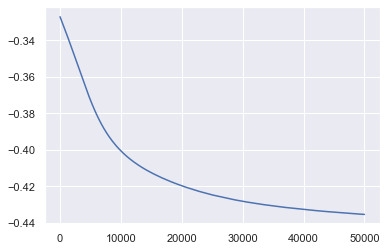

In [22]:
optimizer = torch.optim.SGD(policy_doubly_robust.parameters(), lr=1e-2, weight_decay=1/N)
losses = []

for it in range(iterations):
    policy_probs = policy_doubly_robust(contexts_torch)
    actions_probs = policy_probs[np.arange(N), actions]
    
    pointwise_loss = actions_probs * (rewards_torch - actions_pred_rewards)/propensities_torch + torch.sum(policy_probs * value_based_pred_rewards, dim=-1)
    loss = - torch.mean(pointwise_loss)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
plt.plot(np.arange(iterations), losses)
plt.show()

#### Testing the models Online 

In [23]:
models_to_test = [value_based_model, policy_ips, policy_doubly_robust]
value_result, ips_result, dr_result = AB_test_greedy(models_to_test, N_test)

print('the reward for value based learning is %.4f'%value_result)
print('the reward for policy learning is %.4f'%ips_result)
print('the reward for doubly robust policy learning is %.4f'%dr_result)

100%|██████████| 100000/100000 [00:32<00:00, 3052.34it/s]

the reward for value based learning is 0.3980
the reward for policy learning is 0.4083
the reward for doubly robust policy learning is 0.4167


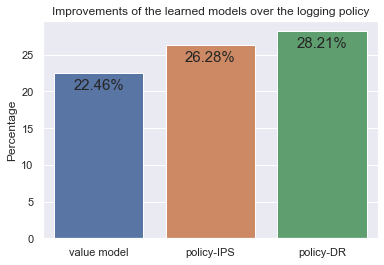

In [24]:
labels = ['value model', 'policy-IPS', 'policy-DR']
perfs = 100.*(np.array([value_result, policy_result, dr_result])/logging_results - 1.0)

splot = sns.barplot(x = labels, y = perfs)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f')+'%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
    
plt.title('Improvements of the learned models over the logging policy')
plt.ylabel('Percentage')
plt.show()

All the methods get us a good improvement over our random logging policy with **DRL** getting us the best resutlts.

### Online Ads Setting : Sparse Rewards 

We deploy our first system to collect/log a dataset from which we want to learn a good recommendation engine.

In [25]:
torch.manual_seed(0)
np.random.seed(0)

contexts, actions, propensities, rewards = online_system_simulator(current_system = pi_0, size = N, setting='sparse')

Let's have a look at the distribution of the rewards gotten in this setting :

the average reward of the logging policy (Random) is 0.0166


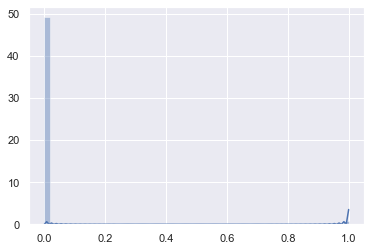

In [26]:
logging_results = np.mean(rewards)
print("the average reward of the logging policy (Random) is %.4f"%logging_results)
sns.distplot(rewards)
plt.show()

One can see that the support of the reward completely changed in this setting, it is binary with a big probability of not having a click, making the reward signal very low.

### Learning a Value model - Sparse Setting:

In this case, as the reward is binary, our value model is a simple **logistic** regression from the contexts to the reward vector for each action: $ \hat{r}_\theta(x,a) = \sigma(\theta_a^Tx) $ with $\theta_a$ being the ath column of our matrix, and $\sigma$ being the sigmoid function.

For a single datapoint $D_i$, the loss function (the negative loglikelihood up to a constant) of our model is :

$$ LM(\hat{r}_\theta, D_i) = - [r_i\log(\hat{r}_\theta(x_i, a_i)) + (1 - r_i)\log(1 - \hat{r}_\theta(x_i, a_i))]  $$

We optimize the average loss over the whole datapoints to obtain the minimum $\hat{r}^*$.

In [27]:
class reward_model_sp(torch.nn.Module):
    def __init__(self, d, K):
        super(reward_model_sp, self).__init__()
        self.theta = torch.nn.Linear(d, K)

    def forward(self, x):
        return torch.sigmoid(self.theta(x))

In [28]:
value_based_model_sp = reward_model_sp(d, K)

contexts_torch = torch.Tensor(contexts)
rewards_torch = torch.Tensor(rewards)
propensities_torch = torch.Tensor(propensities)

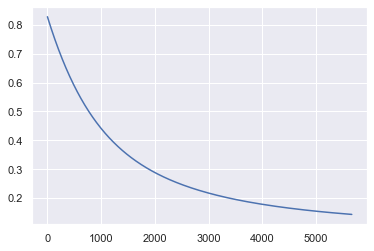

In [29]:
loss_function = torch.nn.BCELoss(reduction='mean')
optimizer = torch.optim.SGD(value_based_model_sp.parameters(), lr=1e-2, weight_decay=1/N)
losses = []

for it in range(iterations):
    full_rewards_pred = value_based_model_sp(contexts_torch)
    action_rewards = full_rewards_pred[np.arange(N), actions]
    loss = loss_function(action_rewards, rewards_torch)
    losses.append(loss.item())
    if (it > 100) and np.isclose(losses[-1], losses[-2], atol=.0, rtol=1e-4) : break
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(np.arange(it + 1), losses)
plt.show()

So as to not learn/derive a policy to check the full DR condition, we're gonna stick to computing how much our reward estimate is correlated with the observed reward. Intuitively, as the observed reward is binary with most entries at 0, the correlation with a continuous signal (probability between [0,1]) would be low.

Let's check if this is true :

In [30]:
#compute \hat{r}
np_pred_rewards = value_based_model_sp(contexts_torch).detach().numpy()
np_actions_pred_rewards = np_pred_rewards[np.arange(N), actions]

#compute its correlation with the observed reward
cor = np.corrcoef(np_actions_pred_rewards, rewards)[0,1]
print("The correlation between the observed reward and the estimated reward is equal to %.4f"%cor)

The correlation between the observed reward and the estimated reward is equal to 0.0838


The correlation between these two signals is low and we expect no variance reduction leading to no improvement over IPS.

In practice, this condition is enough to stop experimenting with Doubly Robust and maybe try other ways of improving the IPS estimator, but for the sake of the tutorial, we are going to check how DR behaves compared to IPS even in this setting.

### Learning a Policy with IPS - Sparse Setting :

In [31]:
policy_ips_sp = policy_model(d, K)

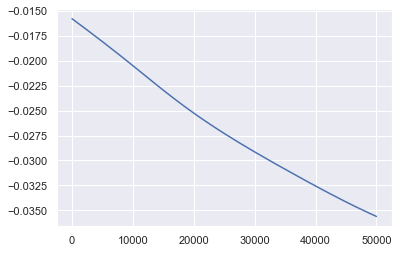

In [32]:
optimizer = torch.optim.SGD(policy_ips_sp.parameters(), lr=1e-2, weight_decay=1/N)
losses = []

for it in range(iterations):
    policy_probs = policy_ips_sp(contexts_torch)
    actions_probs = policy_probs[np.arange(N), actions]
    loss = - torch.mean((actions_probs * rewards_torch)/propensities_torch)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(np.arange(iterations), losses)
plt.show()

as we already learned a policy, let's test out the DR condition :

In [33]:
np_iw_sp = (policy_ips_sp(contexts_torch)[np.arange(N), actions]/propensities_torch).detach().numpy()
np_pred_rewards_sp = value_based_model_sp(contexts_torch).detach().numpy()
np_actions_pred_rewards_sp = np_pred_rewards_sp[np.arange(N), actions]

In [34]:
cov_matrix = np.cov([np_actions_pred_rewards_sp*np_iw_sp, rewards*np_iw_sp])
var, cov = cov_matrix[0,0], cov_matrix[0,1]

In [35]:
print("the variance (left quantity) is equal to %.4f"%var)
print("the 2*covariance (right quantity) is equal to %.4f"%(2*cov))

the variance (left quantity) is equal to 0.0226
the 2*covariance (right quantity) is equal to 0.0188


the DR condition **doesn't hold** and we expect DR to behave badly compared to IPS.

### Learning a Policy with DR - Sparse Setting :

In [36]:
policy_doubly_robust_sp = policy_model(d, K)
value_based_pred_rewards = value_based_model_sp(contexts_torch).detach()
actions_pred_rewards = value_based_pred_rewards[np.arange(N), actions]

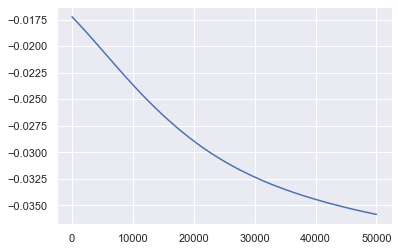

In [37]:
optimizer = torch.optim.SGD(policy_doubly_robust_sp.parameters(), lr=1e-2, weight_decay=1/N)
losses = []

for it in range(iterations):
    policy_probs = policy_doubly_robust_sp(contexts_torch)
    actions_probs = policy_probs[np.arange(N), actions]
    
    pointwise_loss = actions_probs * (rewards_torch - actions_pred_rewards)/propensities_torch + torch.sum(policy_probs * value_based_pred_rewards, dim=-1)
    loss = - torch.mean(pointwise_loss)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
plt.plot(np.arange(iterations), losses)
plt.show()

#### Testing the learned models online  - Sparse Setting :

In [38]:
models_to_test = [value_based_model_sp, policy_ips_sp, policy_doubly_robust_sp]
value_result, ips_result, dr_result = AB_test_greedy(models_to_test, N_test, setting='sparse')

print('the reward for value based learning is %.4f'%value_result)
print('the reward for policy learning is %.4f'%ips_result)
print('the reward for doubly robust policy learning is %.4f'%dr_result)

100%|██████████| 100000/100000 [00:30<00:00, 3307.39it/s]

the reward for value based learning is 0.0244
the reward for policy learning is 0.0266
the reward for doubly robust policy learning is 0.0254


As expected, DR didn't achieve any variance reduction and resulted in a worse policy than IPS, with additional computational cost. 

DR is always motivated by a variance reduction argument, and is what we were trying to show with the notebook. However, how its objective behave in learning is far from being understood theoretically. In the general case, an estimator with good bias-variance tradeoff will help in the learning phase, but if two estimators have the same variance, we need to analyse other properties of the objective to get out with a conclusion.

## Practical Guidelines :

This notebook is not by any mean complete, and is just a attempt to present the doubly robust estimator (a way to combine model and policy) and show with examples when we can expect an improvement with it. To make the comparison interesting, one should use real datasets, more complex simulators, repeat the experiments, change the seeds.. In Practice however, we see that :

- Doubly Robust can be a very efficient method of variance reduction when the reward signal is dense. 
- Once you deal with very sparse rewards, DR can just increase the computational cost without any significant improvement. See [An Empirical Evaluation of Doubly Robust Learning for Recommendation](http://adrem.uantwerpen.be/bibrem/pubs/JeunenREVEAL2020.pdf) for a better empirical evaluation.

